<img src='../img/dust_banner.png' alt='Training school and workshop on dust' align='center' width='100%'></img>

<br>

# Day 1 - Practical exercise - Solution

### About

> You are working for ENAIRE, the air navigation authority for Spain and western Africa. You know that the Canary Islands are prone to Saharan dust events and for this reason, ENAIRE monitors dust on a daily basis. You are the operations analyst for the week of 21-27 February 2020 and responsible for issuing alerts, and if necessary, to mandate required safety measures. 
>
> On 21 February 2020, you are in-charge of analysing the dust forecast and to monitor potential dust events for the coming days. With your new knowledge on aerosol and dust data, you should be able to do this.


### Tasks

#### 1. Brainstorm
  * What dust forecasts do you know about?
  * How do they differ from each other?
  * What satellite data do you know that can be used for dust nowcasting?
  * Which variables can be used to monitor and forecast dust?
  

#### 2. Download and animate the dust forecast from the MONARCH model ([Go to solution](#sdswas_forecast))
  * Download the dust forecast from the MONARCH model for 21 February 2020 and animate the forecast
  * **Hint** 
    * [WMO SDS-WAS dust forecast - Example notebook](../../dust_workshop_part1/03_model-based_data/31_SDS-WAS_MONARCH_dust_forecast.ipynb)
    * [Data access](https://sds-was.aemet.es/forecast-products/dust-forecasts/files-download) (Username: `sdswas.namee.rc@gmail.com`, Password: `BarcelonaDustRC`)



#### 3. Download the MSG SEVIRI Level 1.5 data and visualize the Dust RGB composite ([Go to solution](#msg_seviri))
  * Based on the dust forecast for the next days - which day and hour would you choose for getting a near real-time monitoring of dust from the MSG SEVIRI instrument?
  * **Hint**
    * [MSG SEVIRI Level 1.5 - Example notebook](../../dust_workshop_part1/01_satellite-based_data/14_MSG_dust_product_L1_load_browse.ipynb)
    * [Data access](https://data.eumetsat.int/data/map/EO:EUM:DAT:MSG:HRSEVIRI)



#### 4. Interpret the results
  * Describe the dust forecast event in comparison with the near real-time monitoring from the satellite.
  * What decision as ENAIRE operations analyst do you take? Would you issue an alert? Would you implement some safety measures?

### Module outline
* [1 - Dust forecasts from the MONARCH model](#sdswas_forecast)
* [2 - Meteosat Second Generation SEVIRI Level 1.5 dust RGB](#msg_seviri)

<hr>

##### Load required libraries

In [1]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as pl
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh


from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers
import glob
import pyresample

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='sdswas_forecast'>1. Dust forecasts from the MONARCH model

The first step is to load a `MONARCH` forecast file. The data is disseminated in the `netCDF` format on a daily basis, with the forecast initialisation at 12:00 UTC. Load the `MONARCH` dust forecast of 21 February 2020. You can use the function `open_dataset()` from the xarray Python library.

Once loaded, you see that the data has three dimensions: `lat`, `lon` and `time`; and offers two data variables `od550_dust` and `sconc_dust`.

In [3]:
filepath = '../data/sds_was/2020022112_3H_NMMB-BSC.nc'
file = xr.open_dataset(filepath)
file

<xarray.Dataset>
Dimensions:     (lon: 307, lat: 211, time: 25)
Coordinates:
  * lon         (lon) float64 -31.0 -30.67 -30.33 -30.0 ... 70.33 70.67 71.0
  * lat         (lat) float64 -3.0 -2.667 -2.333 -2.0 ... 66.0 66.33 66.67 67.0
  * time        (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:0...
Data variables:
    od550_dust  (time, lat, lon) float32 ...
    sconc_dust  (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.5.4 (http://c...
    Conventions:               CF-1.2
    history:                   Fri Feb 21 23:50:54 2020: cdo remapbil,regular...
    _FillValue:                -32767.0
    missing_value:             -32767.0
    title:                     Regional Reanalysis 0.5x0.5 deg NMMB-BSC-Dust ...
    History:                   Fri Feb 21 22:12:45 2020: ncrcat -F -O pout_re...
    Grid_type:                 B-grid: vectors interpolated to scalar positions
    Map_Proj:                  Rotated latitude longitude
    NCO:                       4.0.8
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.5.4 (http://c...

Let us then retrieve the data variable `od550_dust`, which is the dust optical depth at 550 nm.

In [4]:
od550_dust = file['od550_dust']
od550_dust

<xarray.DataArray 'od550_dust' (time: 25, lat: 211, lon: 307)>
[1619425 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -31.0 -30.67 -30.33 -30.0 ... 70.0 70.33 70.67 71.0
  * lat      (lat) float64 -3.0 -2.667 -2.333 -2.0 ... 66.0 66.33 66.67 67.0
  * time     (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:00:00
Attributes:
    long_name:  dust optical depth at 550 nm
    units:       
    title:      dust optical depth at 550 nm

<br>

Let us now have a closer look at the dimensions of the data. Let us first inspect the two coordinate dimensions `lat` and `lon`. You can simply access the dimension's `xarray.DataArray` by specifying the name of the dimension. Below you see that the data has a 0.1 x 0.1 degrees resolution and have the following geographical bounds:
* `Longitude: [-63., 101.9]`
* `Latitude: [-11., 71.4]`

In [5]:
latitude = file.lat
longitude = file.lon
latitude, longitude

(<xarray.DataArray 'lat' (lat: 211)>
 array([-3.      , -2.666667, -2.333333, ..., 66.333326, 66.66666 , 66.999993])
 Coordinates:
   * lat      (lat) float64 -3.0 -2.667 -2.333 -2.0 ... 66.0 66.33 66.67 67.0
 Attributes:
     standard_name:  latitude
     long_name:      latitude
     units:          degrees_north
     axis:           Y,
 <xarray.DataArray 'lon' (lon: 307)>
 array([-31.      , -30.666667, -30.333333, ...,  70.333323,  70.666657,
         70.99999 ])
 Coordinates:
   * lon      (lon) float64 -31.0 -30.67 -30.33 -30.0 ... 70.0 70.33 70.67 71.0
 Attributes:
     standard_name:  longitude
     long_name:      longitude
     units:          degrees_east
     axis:           X)

<br>

Now, let us also inspect the time dimension. You see that one daily forecast file has 25 time steps, with three hourly forecast information up to 72 hours (3 days) in advance.

In [6]:
file.time

<xarray.DataArray 'time' (time: 25)>
array(['2020-02-21T12:00:00.000000000', '2020-02-21T15:00:00.000000000',
       '2020-02-21T18:00:00.000000000', '2020-02-21T21:00:00.000000000',
       '2020-02-22T00:00:00.000000000', '2020-02-22T03:00:00.000000000',
       '2020-02-22T06:00:00.000000000', '2020-02-22T09:00:00.000000000',
       '2020-02-22T12:00:00.000000000', '2020-02-22T15:00:00.000000000',
       '2020-02-22T18:00:00.000000000', '2020-02-22T21:00:00.000000000',
       '2020-02-23T00:00:00.000000000', '2020-02-23T03:00:00.000000000',
       '2020-02-23T06:00:00.000000000', '2020-02-23T09:00:00.000000000',
       '2020-02-23T12:00:00.000000000', '2020-02-23T15:00:00.000000000',
       '2020-02-23T18:00:00.000000000', '2020-02-23T21:00:00.000000000',
       '2020-02-24T00:00:00.000000000', '2020-02-24T03:00:00.000000000',
       '2020-02-24T06:00:00.000000000', '2020-02-24T09:00:00.000000000',
       '2020-02-24T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-02-21T12:00:00 ... 2020-02-24T12:00:00
Attributes:
    standard_name:  time

<br>

You can define variables for the attributes of a variable. This can be helpful during data visualization, as the attributes `long_name` and `units` can be added as additional information to the plot. From the `xarray.DataArray`, you simply specify the name of the attribute of interest.

In [7]:
long_name=od550_dust.long_name
units= od550_dust.units

<br>

#### <a id='visualize_bcs_dust'></a>Visualize dust Aerosol Optical Depth

Now we have loaded all necessary information to be able to visualize the dust Aerosol Optical Depth for one specific time during the forecast run. Let us use the function `visualize_pcolormesh()` to visualize the data with the help of the plotting library [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

You have to specify the following keyword arguments:
* `data_array`: the
* `longitude`, `latitude`: longitude and latitude variables of the data variable
* `projection`: one of [Cartopy's projection options](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
* `color_scale`: one of [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* `units`: unit of the data parameter, preferably taken from the data array's attributes
* `long_name`: longname of the data parameter is taken as title of the plot, preferably taken from the data array's attributes
* `vmin`, `vmax`: minimum and maximum bounds of the color range
* `set_global`: False, if data is not global
* `lonmin`, `lonmax`, `latmin`, `latmax`: kwargs have to be specified, if `set_global=False`



Note: in order to have the time information as part of the title, we add the string of the datetime information to the `long_name` variable: `long_name + ' ' + str(od_dust[##,:,:].time.data)`.

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'dust optical depth at 550 nm 2020-02-21T12:00:00.000000000'}>)

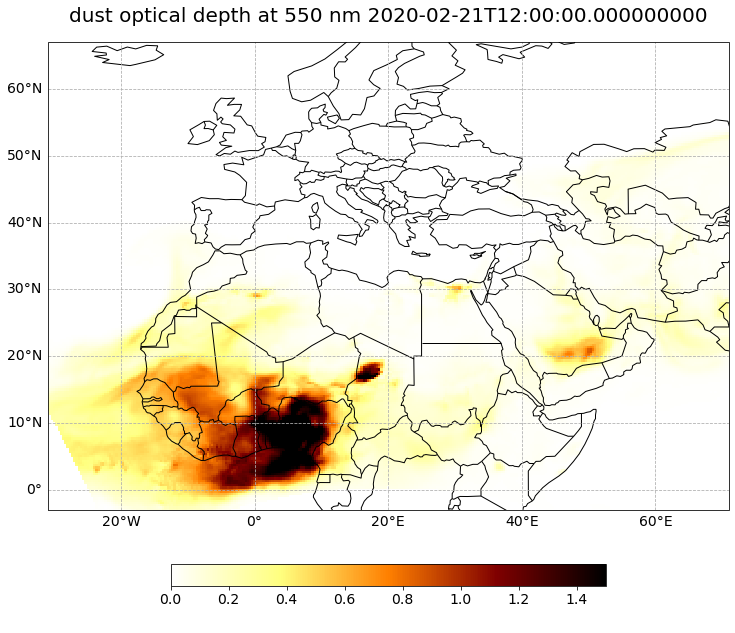

In [8]:
forecast_step=0
visualize_pcolormesh(data_array=od550_dust[forecast_step,:,:],
                     longitude=od550_dust.lon,
                     latitude=od550_dust.lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=units,
                     long_name=long_name + ' ' + str(od550_dust[forecast_step,:,:].time.data),
                     vmin=0, 
                     vmax=1.5,
                     set_global=False,
                     lonmin=longitude.min().data,
                     lonmax=longitude.max().data,
                     latmin=latitude.min().data,
                     latmax=latitude.max().data)

<br>

#### <a id='animate_bcs_dust'></a> Animate dust Aerosol Optical Depth forecasts

In the last step, you can animate the `Dust Aerosol Optical Depth` forecasts in order to see how the trace gas develops over a period of 3 days, from 20th Feb 12 UTC to 24th February 2021.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [9]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=od550_dust[0,:,:],
                     longitude=od550_dust.lon,
                     latitude=od550_dust.lat,
                     projection=ccrs.PlateCarree(),
                     color_scale='afmhot_r',
                     unit=units,
                     long_name=long_name + ' ' + str(od550_dust[0,:,:].time.data),
                     vmin=0, 
                     vmax=1.5,
                     lonmin=longitude.min().data,
                     lonmax=longitude.max().data,
                     latmin=latitude.min().data,
                     latmax=latitude.max().data,
                     set_global=False)

frames = 24

def draw(i):
    img = plt.pcolormesh(od550_dust.lon, 
                         od550_dust.lat, 
                         od550_dust[i,:,:], 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=1.5,
                         shading='auto')
    
    ax.set_title(long_name + ' '+ str(od550_dust.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

In [10]:
HTML(ani.to_html5_video())

<hr>

## <a id='msg_seviri'></a>2. Meteosat Second Generation SEVIRI Level 1.5 true color and dust RGB

From the [EUMETSAT Data Store](https://data.eumetsat.int/data/map/EO:EUM:DAT:MSG:HRSEVIRI?start=2021-02-05T10:27:00.000Z&end=2021-02-06T10:27:00.000Z&sort=start,time,0), we downloaded High Rate SEVIRI Level 1.5 Image data for 23 February 2020 at 18 UTC. 

The data is downloaded as a zip archive. For this reason, we first have to unzip the files.


In [11]:
import zipfile
with zipfile.ZipFile('../data/meteosat/event/2020/02/23/MSG4-SEVI-MSG15-0100-NA-20200223181244.112000000Z-NA.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/meteosat/event/2020/02/23/')

<br>

Then, we can specify the file path and create a variable with the name `file_name`.

In [12]:
file_name = glob.glob('../data/meteosat/event/2020/02/23/MSG4-SEVI-MSG15-0100-NA-20200223181244.112000000Z-NA.nat')
file_name

['../data/meteosat/event/2020/02/23/MSG4-SEVI-MSG15-0100-NA-20200223181244.112000000Z-NA.nat']

<br>

In a next step, we use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for MSG SEVIRI data in the Native format, you can use the `seviri_l1b_native` reader.

In [13]:
scn = Scene(reader="seviri_l1b_native", 
             filenames=file_name)
scn

<br>

#### Load the RGB composite ID *natural color*

Let us define load the composite ID `natural_color`. This list variable can then be passed to the function `load()`. Per default, scenes are loaded with the nort pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [ ]:
composite_id = ["natural_color"]
scn.load(composite_id, upper_right_corner="NE")

<br>

A print of the Scene object `scn` shows you that one band is available: `natural_color`

In [16]:
print(scn)

<xarray.DataArray 'where-0d97cf90ad028dfffd61363f78fca42a' (bands: 3, y: 3712, x: 3712)>
dask.array<where, shape=(3, 3712, 3712), dtype=float64, chunksize=(1, 3712, 3712), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 5.569e+06 5.566e+06 5.563e+06 ... -5.563e+06 -5.566e+06
  * x        (x) float64 -5.569e+06 -5.566e+06 ... 5.563e+06 5.566e+06
  * bands    (bands) <U1 'R' 'G' 'B'
Attributes:
    end_time:                               2020-02-23 18:15:11.171248
    sun_earth_distance_correction_applied:  True
    start_time:                             2020-02-23 18:00:11.057487
    standard_name:                          natural_color
    area:                                   Area ID: msg_seviri_fes_3km\nDesc...
    orbital_parameters:                     {'projection_longitude': 0.0, 'pr...
    resolution:                             3000.403165817
    platform_name:                    

<br>

#### Generate a geographical subset over Canary Islands

Crop the data with x and y values in original projection unit (x_min, y_min, x_max, y_max). Below we apply the funcion `crop()` and use the keyword argument `xy_bbox=(xmin, ymin, xmax, ymax)` in order to crop the file based on an area in original projection unit.
For the bbox information we use the following settings: `xmin=-20E5, ymin=23E5, xmax=-5E5, ymax=35E5`.

Then, let's visualize the cropped image with the function `show()`.

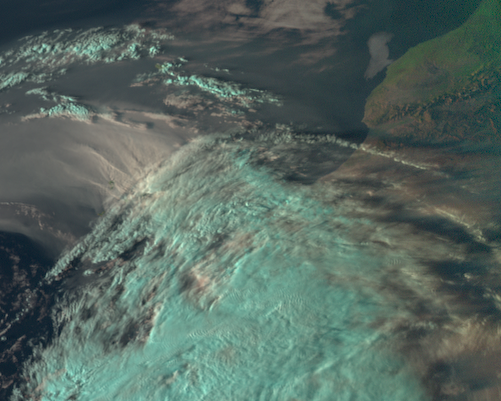

In [18]:
scn_cropped = scn.crop(xy_bbox=(-20E5, 23E5, -5E5, 35E5))
scn_cropped.show("natural_color")

<br>

Let us store the area definition as variable.

In [19]:
area = scn_cropped['natural_color'].attrs['area']
area

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Area ID: msg_seviri_fes_3km
Description: MSG SEVIRI Full Earth Scanning service area definition with 3 km resolution
Projection: {'a': '6378169', 'h': '35785831', 'lon_0': '0', 'no_defs': 'None', 'proj': 'geos', 'rf': '295.488065897014', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 501
Number of rows: 401
Area extent: (-2002769.1132, 2299809.0266, -499567.1271, 3502970.6961)

<br>

Next, use the area definition to resample the loaded Scene object. Afterwards, you can visualize the resampled image with the function `show()`.

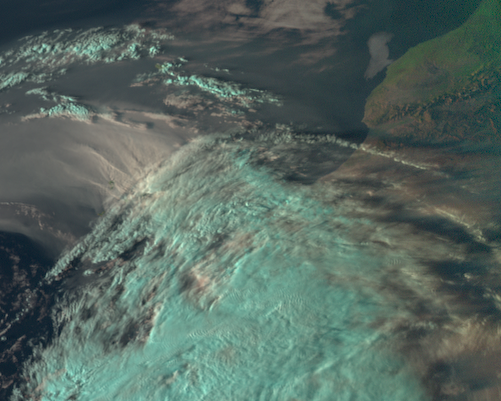

In [21]:
scn_resample_nc = scn.resample(area)
scn_resample_nc.show('natural_color')

<br>

#### Load, visualize and interpret the MSG SEVIRI Dust RGB composite

Let us reload the file with the Scene constructor.

In [22]:
scn2 = Scene(reader="seviri_l1b_native", 
             filenames=file_name)
scn2

Let us define a composite ID for `dust` in a list. This list variable can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [24]:
composite_id = ["dust"]
scn2.load(composite_id, upper_right_corner="NE")

<br>

Next, use the same area definition to resample the loaded Scene object.

In [26]:
scn2_resample_nc = scn2.resample(area)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<br>

Afterwards, you can visualize the resampled image with the function `show()`.

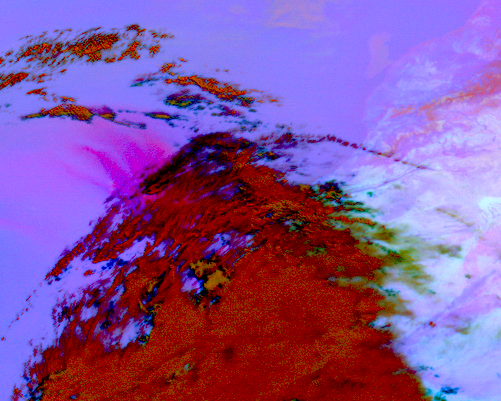

In [27]:
scn2_resample_nc.show('dust')

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.